In [3]:
%load_ext autoreload

In [106]:
%autoreload 2

import os
import sys
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import xgboost as xgb
from src.utils import load_all_locations
from sklearn.metrics import mean_absolute_error


sns.set_theme(style="darkgrid")

In [65]:
data = load_all_locations()

In [79]:
def create_time_features(df):
    df['hour'] = df.time.dt.hour
    df['dayofmonth'] = df.time.dt.day
    df['dayofweek'] = df.time.dt.dayofweek
    df['quarter'] = df.time.dt.quarter
    df['month'] = df.time.dt.month
    df['year'] = df.time.dt.year
    df['dayofyear'] = df.time.dt.dayofyear
    return df

In [99]:
X, y = data[0].copy(), data[1].copy()


# One-hot Encoding
X = X.reset_index().drop(columns="index")
one_hot = pd.get_dummies(X["location"]).astype(int)
X = X.drop("location", axis=1)
X = pd.merge(X, one_hot, left_index=True, right_index=True)

# Add time based features
X = create_time_features(X)

# Drop datetime
X = X.drop(columns=["time"])

# Drop missing column values
nan_columns = X.columns[X.isna().any()].tolist()
X = X.drop(columns=nan_columns)

X.shape, y.shape


((81118, 53), (81118, 4))

In [154]:
X_train = X[X.set_type == "TRAIN"].copy().drop(columns=["set_type"])
y_train = y[y.set_type == "TRAIN"].copy()["y"]

# X_test = X[(X.set_type == "TEST")].copy().drop(columns=["set_type"])
# y_test = y[(y.set_type == "TEST")].copy()["y"]
X_test = X[(X.set_type == "TEST") & (X.A == True)].copy().drop(columns=["set_type"])
y_test = y[(y.set_type == "TEST") & (y.location == "A")].copy()["y"]

model = xgb.XGBRegressor(
    max_depth=7,
    colsample_bytree=0.8,
    eta=0.1,
    n_estimators=90,
    reg_alpha=0.01,
    reg_lambda=0.01
)

model.fit(X_train, y_train)

prediction = model.predict(X_test)

In [157]:
print(
    "MAE: ",
    round(
        mean_absolute_error(
            y_true=y_test,
            y_pred=prediction,
        ),
        3,
    ),
)

MAE:  121.409


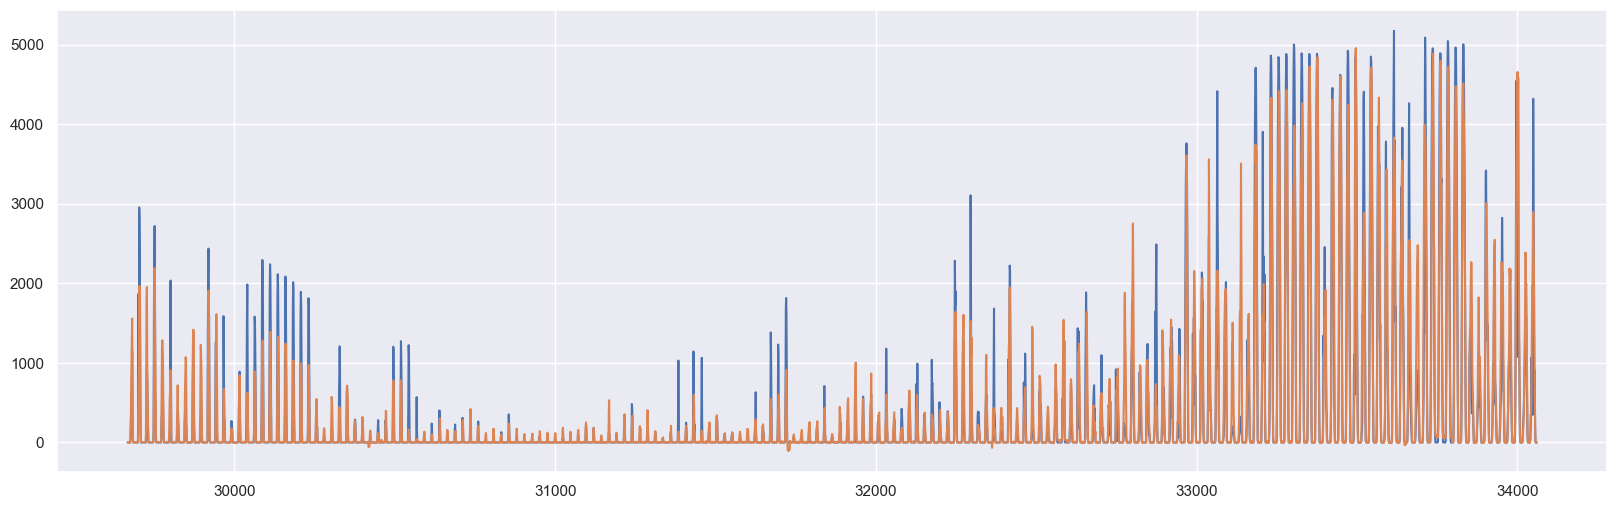

In [159]:
fig, ax = plt.subplots(figsize=(20, 6))

plt.plot(y_test.index, y_test)
plt.plot(y_test.index, prediction)